In [1]:
# !pip install qiskit --quiet
# !pip install qiskit-machine-learning --quiet
# !pip install pylatexenc --quiet

In [155]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Linear, Dropout2d, MaxPool2d, Conv2d
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import cat, no_grad, manual_seed
from torch import optim
from torch.nn import NLLLoss

from qiskit import QuantumCircuit, Aer
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.opflow import AerPauliExpectation
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
from qiskit.opflow import StateFn
from qiskit.opflow import Z, ListOp

# Loading the dataset

In [145]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 16
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

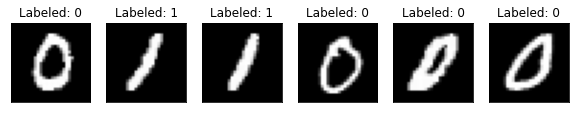

In [146]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [147]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [142]:
# cluster state
def cluster_state_circuit(bits):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    qc.h(bits)
    for this_bit, next_bit in zip(bits, bits[1:]):
        qc.cz(this_bit, next_bit)
    if(len(bits)!= 2):
        qc.cz(bits[0], bits[-1])
    return qc

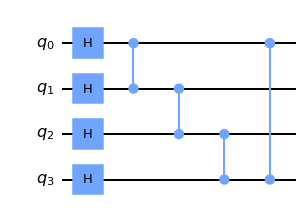

In [143]:
circuit = cluster_state_circuit(4)
circuit.draw('mpl')

In [144]:
def one_qubit_unitary(thetas):
    qc = QuantumCircuit(1)
    qc.rx(thetas[0], 0)
    qc.ry(thetas[1], 0)
    qc.rz(thetas[2], 0)
    return qc

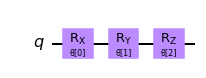

In [85]:
thetas = ParameterVector('θ', length=3)
circuit = one_qubit_unitary(thetas)
circuit.draw('mpl')

In [86]:
def two_qubit_unitary(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [1])
    qc.rzz(thetas[6],0, 1)
    qc.ryy(thetas[7],0, 1)
    qc.rxx(thetas[8],0, 1)
    qc = qc.compose(one_qubit_unitary(thetas[9:12]), [0])
    qc = qc.compose(one_qubit_unitary(thetas[12:]), [1])
    return qc

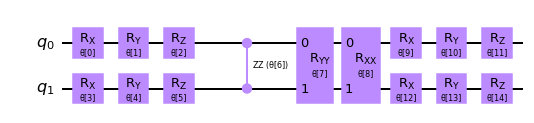

In [87]:
thetas = ParameterVector('θ', length=15)
circuit = two_qubit_unitary(thetas)
circuit.draw('mpl')

In [88]:
def two_qubit_pool(thetas):
    qc = QuantumCircuit(2)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]), [1])
    qc = qc.compose(one_qubit_unitary(thetas[3:6]), [0])
    qc.cnot(0,1)
    qc = qc.compose(one_qubit_unitary(thetas[0:3]).inverse(), [1])
    return qc

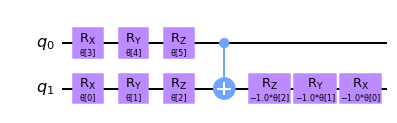

In [89]:
thetas = ParameterVector('θ', length=6)
circuit = two_qubit_pool(thetas)
circuit.draw('mpl')

In [90]:
def quantum_conv_circuit(bits, thetas):
    qc = QuantumCircuit(bits)
    bits = list(range(bits))
    for first, second in zip(bits[0::2], bits[1::2]):
        qc = qc.compose(two_qubit_unitary(thetas), [first,second])
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        qc = qc.compose(two_qubit_unitary(thetas), [first, second])
    return qc

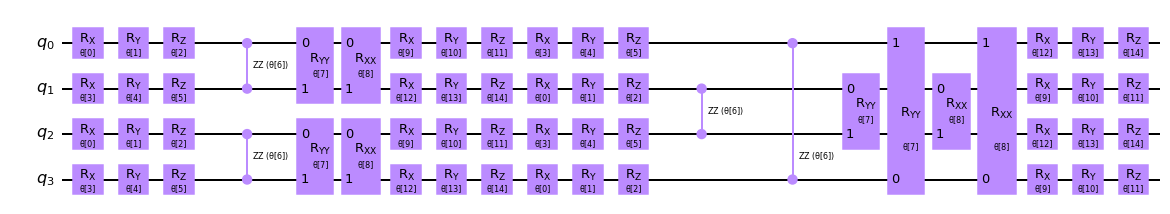

In [91]:
thetas = ParameterVector('θ', length=16)
circuit = quantum_conv_circuit(4, thetas)
circuit.draw('mpl')

In [63]:
def quantum_pool_circuit(sources, sinks, thetas):
    qc = QuantumCircuit(len(sources) + len(sinks))
    for source, sink in zip(sources, sinks):
        qc = qc.compose(two_qubit_pool(thetas), [source, sink])
    return qc

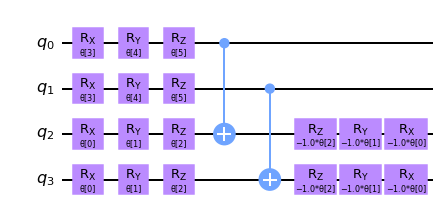

In [67]:
thetas = ParameterVector('θ', length=6)
sources = [0,1]
sinks = [2,3]
circuit = quantum_pool_circuit(sources, sinks, thetas)
circuit.draw('mpl')

In [107]:
# Define and create QNN
def create_qcnn(n, observables):
    
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    in_thetas = ParameterVector('x', length=n)
    
    cluster_map = cluster_state_circuit(n)
    feature_map = QuantumCircuit(n, name="Angle Encoding")
    
    for i in range(n):
        feature_map.ry(in_thetas[i], i)
    
    ansatz = QuantumCircuit(n, name="Ansatz")
    
    # Alternating conv and pool layers
    i = 1
    thetas = []
    num_layers = 2 # Conv + pool layers
    while (n//(2**(i-1)) >1):
        
        # conv layer
        bits = list(range(n - (n//(2**(i-1))), n))
        params_c = ParameterVector('θc'+str(i), length=16)
        ansatz.compose(quantum_conv_circuit(len(bits),params_c), bits, inplace=True)
        thetas += list(params_c)
        
        # pooling layer
        l = len(bits)
        sources = list(range(l//2))
        sinks = list(range(l//2,l))
        
        params_p = ParameterVector('θp'+str(i), length=6)
        ansatz.compose(quantum_pool_circuit(sources, sinks, params_p), bits ,inplace=True)
        thetas += list(params_p)
        
        i += 1
    
    qc = QuantumCircuit(n)
    qc.compose(cluster_map, range(n),inplace=True)
    qc.compose(feature_map, range(n),inplace=True)
    qc.compose(ansatz, range(n),inplace=True)
    
    operator = ~StateFn(observables) @ StateFn(qc)
    
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qcnn_operator = OpflowQNN( operator,
                      input_params= in_thetas,
                      weight_params= thetas,
                      input_gradients=True,
                      exp_val = AerPauliExpectation(),
                      quantum_instance=qi)
    return qcnn_operator, qc

In [111]:
observables = ListOp([Z])
operator, circuit = create_qcnn(4,observables)

In [117]:
operator.operator

ComposedOp([OperatorStateFn(ListOp([PauliOp(Pauli('ZIII'), coeff=1.0)], coeff=1.0, abelian=False), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f8ca097d390>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

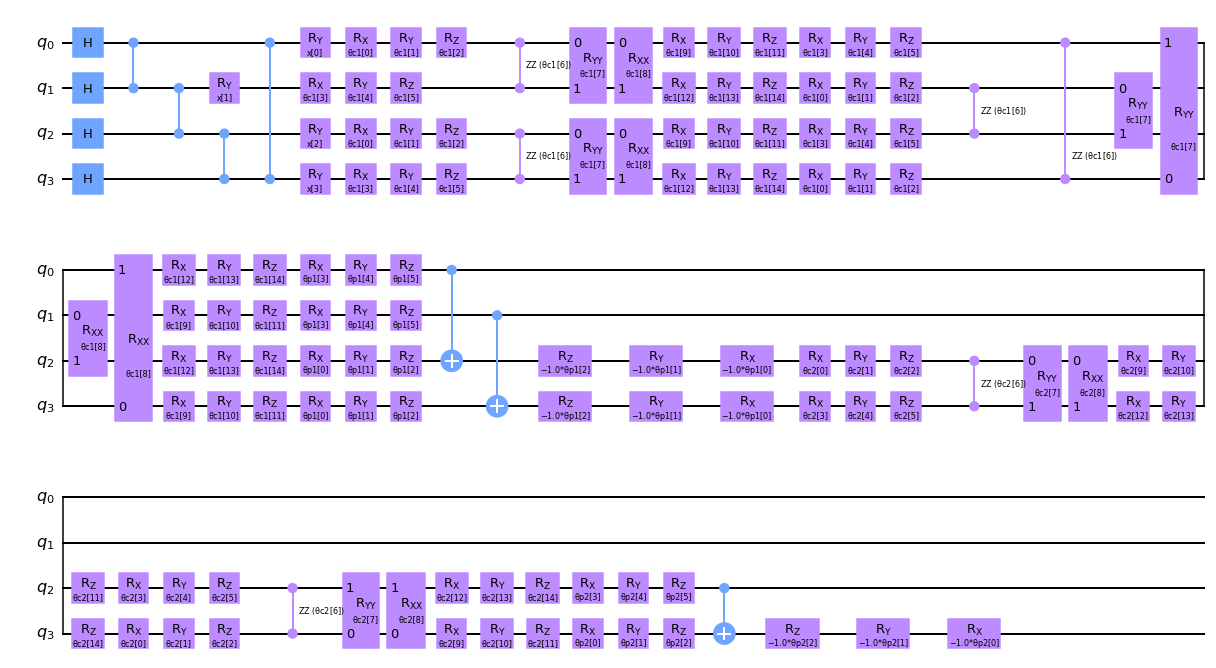

In [116]:
circuit.draw('mpl')

In [149]:
class Net(Module):
    def __init__(self, qcnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 4)  # 4-dimensional input to QCNN
        self.qcnn = TorchConnector(qcnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QCNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qcnn(x)  # apply QCNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

In [150]:
model = Net(operator)

In [151]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [152]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 1  # Set number of epochs
history = []  # Store history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        acc = accuracy(output, target)
        loss = loss_func(output, target)  # Calculate loss
        history.append({'loss':loss.item(), 'acc':acc}) # Store training loss and acc
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights 
        print(history[-1])
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, history[-1]))

{'loss': -0.6060770153999329, 'acc': tensor(0.5625)}
{'loss': -0.4995092451572418, 'acc': tensor(0.5000)}
{'loss': -0.7124021649360657, 'acc': tensor(0.6250)}
{'loss': -0.39292672276496887, 'acc': tensor(0.4375)}
{'loss': -0.2868047058582306, 'acc': tensor(0.3750)}
{'loss': -0.28687024116516113, 'acc': tensor(0.3750)}
{'loss': -0.4999457001686096, 'acc': tensor(0.5000)}
{'loss': -0.07376880198717117, 'acc': tensor(0.2500)}
{'loss': -0.8187655806541443, 'acc': tensor(0.6875)}
{'loss': -0.7123372554779053, 'acc': tensor(0.6250)}
{'loss': -0.4997766613960266, 'acc': tensor(0.5000)}
{'loss': -0.49925321340560913, 'acc': tensor(0.5000)}
{'loss': -0.7117511630058289, 'acc': tensor(0.6250)}


TypeError: unsupported format string passed to dict.__format__

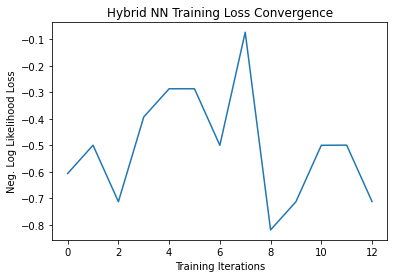

In [153]:
# Plot loss convergence
loss_list = [x['loss'] for x in history]
plt.plot(loss_list)
plt.title("Hybrid NN Training Loss Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

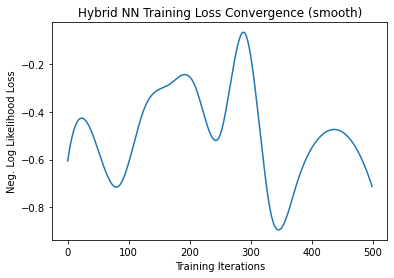

In [156]:
x = np.arange(0,len(loss_list),1)
spline = make_interp_spline(x, loss_list)
x = np.linspace(x.min(), x.max(), 500)
y = spline(x)
plt.plot(y)
plt.title("Hybrid NN Training Loss Convergence (smooth)")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

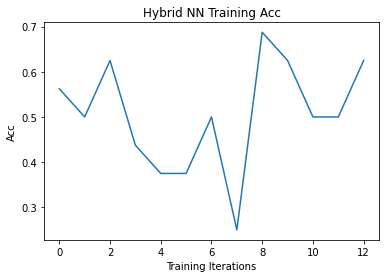

In [157]:
acc_list = [x['acc'] for x in history]
plt.plot(acc_list)
plt.title("Hybrid NN Training Acc")
plt.xlabel("Training Iterations")
plt.ylabel("Acc")
plt.show()

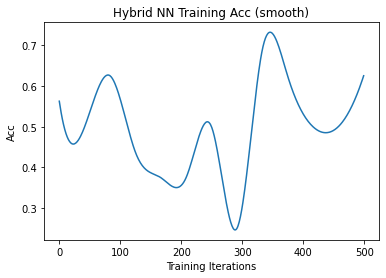

In [158]:
x = np.arange(0,len(acc_list),1)
spline = make_interp_spline(x, acc_list)
x = np.linspace(x.min(), x.max(), 500)
y = spline(x)
plt.plot(y)
plt.title("Hybrid NN Training Acc (smooth)")
plt.xlabel("Training Iterations")
plt.ylabel("Acc")
plt.show()

In [161]:
torch.save(model.state_dict(), "model.pt")

In [162]:
observables = ListOp([Z])
operator, _ = create_qcnn(4,observables)
model = Net(operator)
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [165]:
model.eval()  # set model to evaluation mode
total_loss = []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -0.5453
	Accuracy: 44.6%


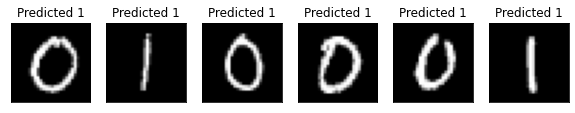

In [167]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1
